# Email Spam Detection Pipeline

This notebook demonstrates how a **single Python package** (`src/`) can
handle:

* configuration via YAML
* data loading & merging
* pipeline construction + hyper‑parameter search
* evaluation and model persistence

The core script is `run.py` – the notebook simply calls the same helper
functions, but with added visualisation.  The code structure follows:


src

├── utils.py   # misc helpers for the entire project

├── config.py  # load_experiment_config

├── data_loader.py  # download_and_merge / split

├── model_builder.py  # build_pipeline + build_grid_search

├── trainer.py  # fit_and_evaluate + save_model

└── pipeline_arch  # get only the *'important'* pipeline params

In [44]:
# ---- Imports --------------------------------------------------------------
import json
from pathlib import Path
from glob import glob
from typing import Dict, Any, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_seq_items", None)

pd.set_option("display.expand_frame_repr", False)

In [45]:
from src.utils import load_json

final_dirs = Path("experiments/").glob("*/final")
rows: List[Dict[str, Any]] = []
for final_dir in final_dirs:
    exp_dir = final_dir.parent
    name = exp_dir.name
    training_metrics = load_json(final_dir / "train_metrics.json") or load_json(final_dir / "training_metrics.json")
    inference_metrics = load_json(final_dir / "inference_metrics.json")
    results = load_json(exp_dir / "results.json")

    row: Dict[str, Any] = {"experiment": name}

    if training_metrics:
        # row["train_total_sec"] = training_metrics.get("total_training_time_sec")
        row["train_sps"] = training_metrics.get("time_per_sample_sec")
        # row["n_train_samples"] = training_metrics.get("num_samples")
        row["model_size_mb"] = training_metrics.get("model_file_size_mb")
        
        report = training_metrics.get("overfit_classification_report")
        row["train_accuracy"] = report.get("accuracy", np.nan)
        row["train_weighted_f1"] = report.get("weighted avg", {}).get("f1-score", np.nan)
        # row["train_macro_f1"] = report.get("macro avg", {}).get("f1-score", np.nan)

    if inference_metrics:
        # row["val_auc"] = inference_metrics.get("auc", np.nan)
        row["per_sample_ms"] = inference_metrics.get("per_sample_median_ms", np.nan)

        report = inference_metrics.get("classification_report", {})
        row["val_accuracy"] = report.get("accuracy", np.nan)
        row["val_weighted_f1"] = report.get("weighted avg", {}).get("f1-score", np.nan)

    if results:
        row['vec'] = results["best_arch"]["vec"]["class_name"]
        row['clf'] = results["best_arch"]["clf"]["class_name"]
    rows.append(row)

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.DataFrame(rows)
df["f1_score"] = df["val_weighted_f1"]/df["train_weighted_f1"]
df["acc_score"] = df["val_accuracy"]/df["train_accuracy"]
df

,experiment,train_sps,model_size_mb,train_accuracy,train_weighted_f1,per_sample_ms,val_accuracy,val_weighted_f1,vec,clf,f1_score,acc_score
0,minisbert_LogReg,0.008292,87.165101,0.987950,0.987842,20.67660,0.769,0.770714,SBERTVectorizer,LogisticRegression,0.780200,0.778379
1,minisbert_SVC,0.007849,87.164930,0.987242,0.987126,21.59775,0.760,0.762018,SBERTVectorizer,LinearSVC,0.771955,0.769822
2,TFIDF_NB,0.000236,5.247895,0.997637,0.997630,1.19295,0.856,0.858300,TfidfVectorizer,MultinomialNB,0.860339,0.858027
3,TFIDF_SVC,0.000385,14.902360,1.000000,1.000000,0.56165,0.775,0.769106,TfidfVectorizer,LinearSVC,0.769106,0.775000


Соотношение оценок валидации и обучения позволяет оценить обобщающую способность каждой модели. Соотношение, близкое к 1, указывает на хорошую обобщающую способность.


График 1. Баланс между качеством модели и скоростью инференса

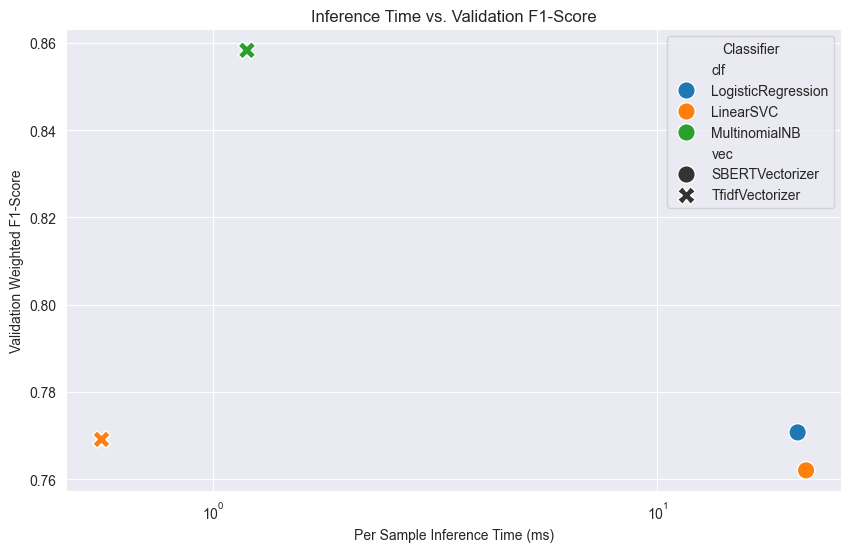

In [46]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='per_sample_ms', y='val_weighted_f1', hue='clf',  style='vec', s=160, data=df)
plt.title('Inference Time vs. Validation F1-Score')
plt.xlabel('Per Sample Inference Time (ms)')
plt.ylabel('Validation Weighted F1-Score')
plt.legend(title='Classifier')
plt.xscale('log')
plt.grid(True)
plt.show()

График 2. Баланс между размером модели и скоростью инференса

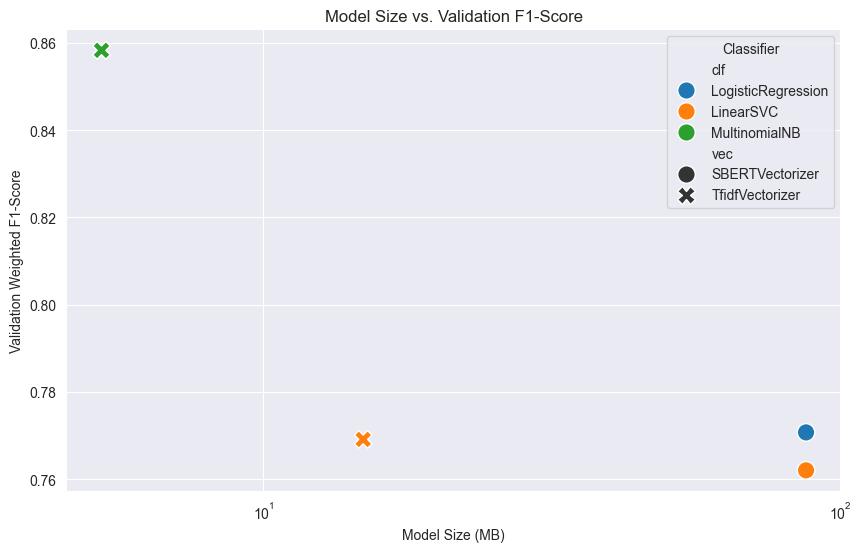

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='model_size_mb', y='val_weighted_f1', hue='clf', style='vec', data=df, s=160)
plt.title('Model Size vs. Validation F1-Score')
plt.xlabel('Model Size (MB)')
plt.ylabel('Validation Weighted F1-Score')
plt.legend(title='Classifier')
plt.xscale('log')
plt.grid(True)
plt.show()

График 3. Средний результат разных классификаторов

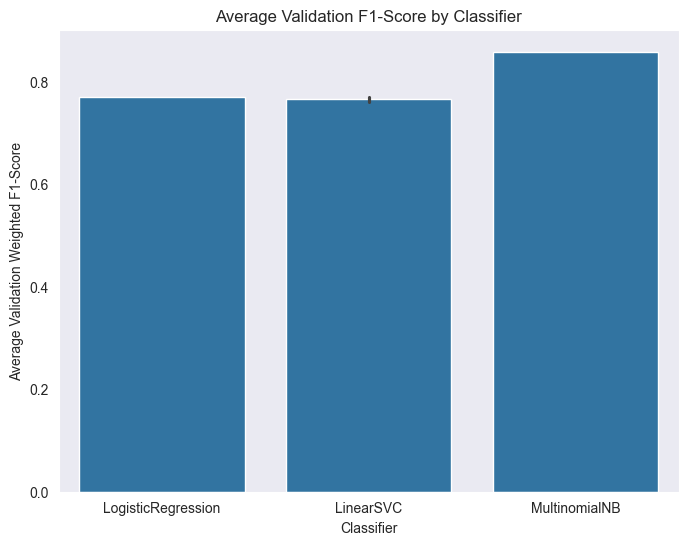

In [48]:
plt.figure(figsize=(8, 6))
sns.barplot(x='clf', y='val_weighted_f1', data=df, errorbar="sd") #errorbar="sd" - стандартное отклонение
plt.title('Average Validation F1-Score by Classifier')
plt.xlabel('Classifier')
plt.ylabel('Average Validation Weighted F1-Score')
plt.grid(axis='y')
plt.show()

График 4. Распределение качества моделей в зависимости от классификатора

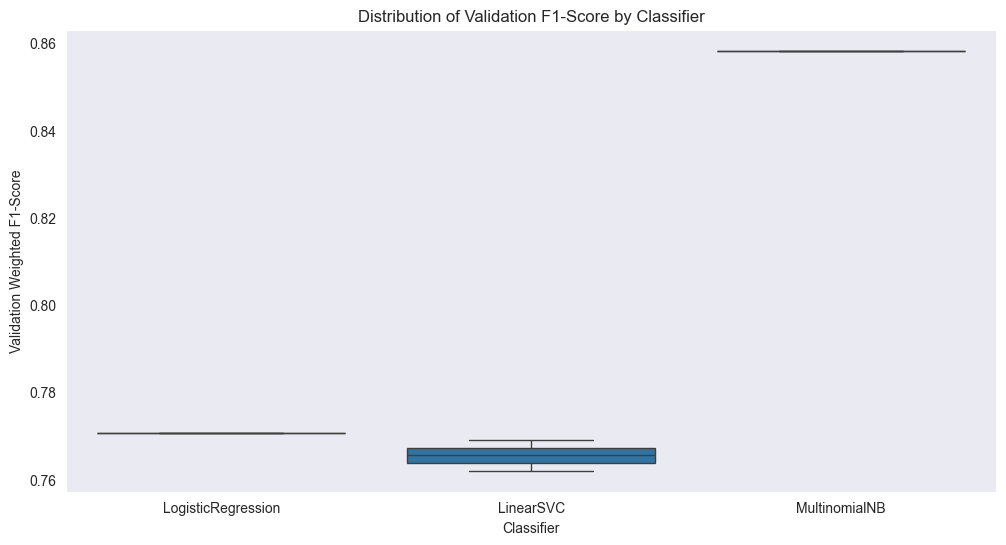

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='clf', y='val_weighted_f1', data=df)
plt.title('Distribution of Validation F1-Score by Classifier')
plt.xlabel('Classifier')
plt.ylabel('Validation Weighted F1-Score')
plt.grid(axis='y')
plt.show()

График 5. Недообучение vs. Переобучение (по точности)

Чем ниже точка на графике, тем хуже эта модель показывает себя на незнакомых данных.

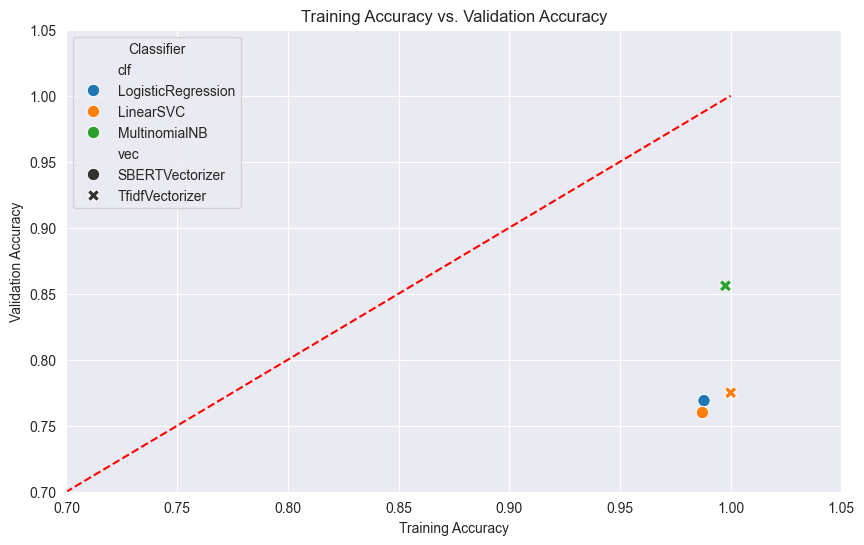

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='train_accuracy', y='val_accuracy', hue='clf', style='vec', data=df, s=80)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')
plt.legend(title='Classifier')

plt.plot([0, 1], [0, 1], color='red', linestyle='--') # y=x
plt.xlim([0.7, None])
plt.ylim([0.7, None])
plt.grid(True)
plt.show()


График 6. Недообучение vs. Переобучение (по f1-score)

Чем ниже точка на графике, тем хуже эта модель показывает себя на незнакомых данных.

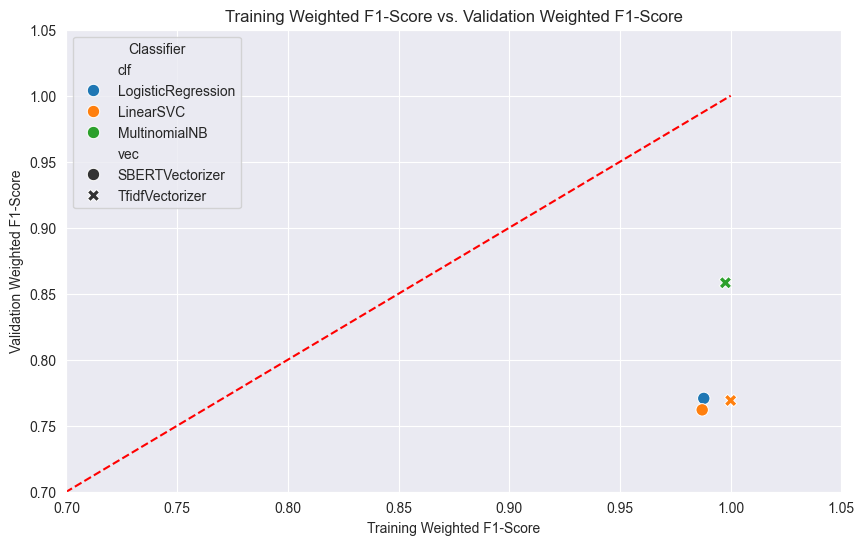

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='train_weighted_f1', y='val_weighted_f1', hue='clf', style='vec', data=df, s=80)
plt.title('Training Weighted F1-Score vs. Validation Weighted F1-Score')
plt.xlabel('Training Weighted F1-Score')
plt.ylabel('Validation Weighted F1-Score')
plt.legend(title='Classifier')

plt.plot([0, 1], [0, 1], color='red', linestyle='--') # y=x
plt.xlim([0.7, None])
plt.ylim([0.7, None])
plt.grid(True)
plt.show()

## Итоги
Судя по результатам, модель **TFIDF_NB** достигла наивысшей точности валидации (85,6%) и взвешенной оценки F1 (85,8%) при небольшом размере модели (5,25 МБ).
Использование более крупной модели векторизации в **SBERT_LogReg** (относительно minisbert_LogReg) не принесло желаемого увеличения в метриках, модель только стала больше по объёму.

По какой-то причине использование более сложных методов векторизации не привело к улучшению метрик, и в изученном пространстве моделей и их параметров лучшим пайплайном оказалось использование векторизации TfIdf и метода Наивного Байеса для классификации.